In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import umap
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# local imports
import geneformer_utils as gtu

sns.set_style('white')

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
reload(gtu)
torch.cuda.empty_cache()
num_cells = 1000

"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_skin.dataset"
df = gtu.load_data_as_dataframe(data_path, num_cells=num_cells, shuffle=True)

# convert into arrow dataset
data = Dataset.from_pandas(df)

# useful for later
features = df.columns.to_list()
features.remove("input_ids")

print(f"{df.shape=}")
df.head()

df.shape=(1000, 13)


,input_ids,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender,length
0,"[5592, 2124, 19437, 5950, 10774, 15987, 13326,...",Skin,10X,TSP10,nan,2608.0,1021,muscle cell,muscle cells,True,stromal,male,969
1,"[1867, 690, 3842, 9008, 10057, 5950, 7673, 520...",Skin,smartseq2,TSP10,abdomen,460718.0,1602,"cd4-positive, alpha-beta memory t cell",CD4-positive memory T cell,True,immune,male,1235
2,"[10259, 6179, 3287, 12607, 15169, 1947, 15243,...",Skin,10X,TSP10,nan,5981.0,1830,endothelial cell,endothelial cells,True,endothelial,male,1739
3,"[9227, 16598, 7135, 11054, 13139, 15987, 12172...",Skin,10X,TSP14,Abdomen,11518.0,2391,stromal cell,stromal cells,True,stromal,male,2048
4,"[6961, 5395, 454, 12172, 4552, 1950, 9034, 165...",Skin,10X,TSP14,Chest,5241.0,1999,stromal cell,stromal cells,True,stromal,male,1971


In [11]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
print(f"{embs.shape=}")
embs.head()

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

embs.shape=(10, 512)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.039079,-0.392290,1.211794,-0.025788,-0.111559,0.082125,-0.456347,-0.066531,0.133483,0.346492,...,0.419868,-0.127525,0.122002,-0.102029,0.096131,0.074500,0.204367,0.172668,0.625405,-0.452721
1,0.158658,-0.191100,1.369706,-0.029772,-0.050748,0.040865,-0.448716,0.050930,0.055160,0.406536,...,0.475399,0.254881,0.155616,-0.228250,0.191237,0.032710,0.129895,0.248460,0.410599,-0.476916
2,0.132042,-0.273122,1.331733,-0.117478,-0.005064,0.195773,-0.210718,0.023691,0.086678,0.428217,...,0.485645,-0.037530,0.070694,-0.286831,0.233100,-0.121152,0.169004,0.269247,0.279236,-0.455915
3,0.052614,-0.252404,1.265579,-0.143180,-0.111783,0.176471,-0.383694,-0.018966,0.140319,0.409039,...,0.348553,-0.088282,0.057150,-0.177896,0.188712,-0.119137,0.305328,0.090910,0.504059,-0.422115
4,0.084030,-0.153801,1.313651,0.014120,-0.050445,-0.022425,-0.440388,-0.128761,0.050532,0.590567,...,0.509967,-0.123270,0.008716,-0.067372,0.161830,-0.017174,0.292219,0.101274,0.561426,-0.442150


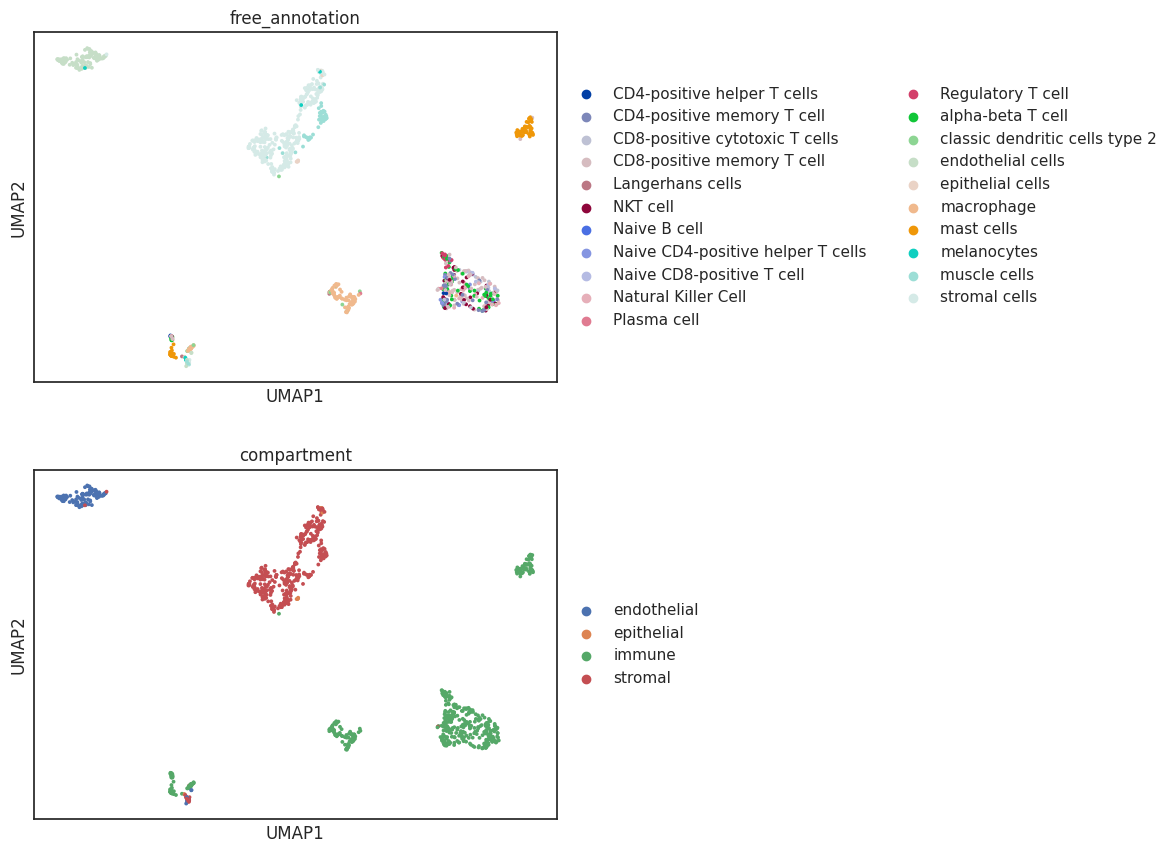

AnnData object with n_obs × n_vars = 1000 × 512
    obs: 'input_ids', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'length'
    uns: 'pca', 'neighbors', 'umap', 'free_annotation_colors', 'compartment_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["free_annotation", "compartment"],
    ncols=1,
    size=30,
)

adata

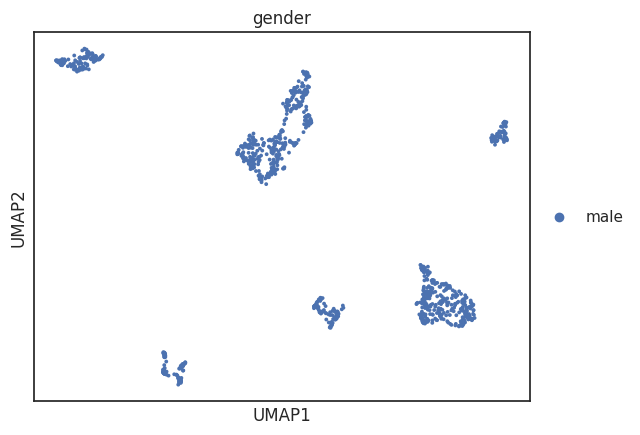

In [5]:
sc.pl.umap(
    adata,
    color=["gender"],
    ncols=1,
    size=30,
)

In [6]:
reload(gtu)
torch.cuda.empty_cache()

"""Load the data"""
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_skin.dataset"
df = gtu.load_data_as_dataframe(data_path)
df = df[df['free_annotation'] == "skeletal muscle cells"]
print(f"{df.shape=}")
data = Dataset.from_pandas(df)

# gene embedding
gene_embedding = gtu.extract_embedding_in_mem(model, data, emb_mode='gene')
print(f"{gene_embedding.shape=}")

# cell embedding
cell_embedding = gtu.extract_embedding_in_mem(model, data, emb_mode='cell')
print(f"{cell_embedding.shape=}")

df.shape=(10, 13)


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


gene_embedding.shape=(10, 2048, 512)


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

cell_embedding.shape=(10, 512)


# Test cell embedding anf gene embedding

In [7]:
cell_embedding.to_numpy()[0, 0:3]

array([ 0.03907862, -0.3922897 ,  1.2117945 ], dtype=float32)

In [8]:
test = gene_embedding.mean(axis=1)
test[0, 0:3]

array([ 0.03907861, -0.39228982,  1.211793  ], dtype=float32)

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)